In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict 

In [2]:
with open('coffee_words.pickle','rb') as read_file:
    coffee = pickle.load(read_file)
with open('coffee_ratings.pickle','rb') as read_file:
    ratings = pickle.load(read_file)

In [3]:
coffee.head()

,Roaster,Review,Notes,TLDR
0,Jackrabbit Java,"Yeasty, richly sweet-savory. Fresh-baked bread...",Processed by the anaerobic natural method (who...,An anaerobically processed coffee with rich st...
1,Jackrabbit Java,"Balanced, sweet-toned, floral. Tea rose, cocoa...",Produced at Mahembe Farm and processed at the ...,"A friendly, classic Rwanda cup: balanced, deep..."
2,Red Rooster Coffee Roaster,"Delicate, deep; complex. Pomegranate, macadami...",This coffee earned the highest rating in a cup...,An intricately original natural-processed Colo...
3,Paradise Roasters,"Very sweet, floral-toned. Freesia, pink grapef...",This coffee tied for the second-highest rating...,A sweetly evocative presentation of Colombia P...
4,Kakalove Cafe,"Opulent, richly sweet-tart-savory. Black curra...",This coffee tied for the second-highest rating...,"A rich, complex, decadently sweet cup processe..."


In [4]:
ratings = ratings.reset_index().rename(columns={'index':'Roaster'})
ratings.head()

,Roaster,Overall,Roaster Location,Coffee Origin,Roast Level,Agtron,Est. Price,Review Date,Aroma,Body,Flavor,Aftertaste,Acidity
0,Jackrabbit Java,93,"Thermopolis, Wyoming",Costa Rica,Medium-Light,54/72,$20.00/12 ounces,February 2021,9,9,9,8,8
1,Jackrabbit Java,92,"Thermopolis, Wyoming","Nyamasheke District, Rwanda",Medium-Light,58/76,$20.00/12 ounces,February 2021,9,8,9,8,8
2,Red Rooster Coffee Roaster,96,"Floyd, Virginia","Los Naranjos, La Argentina, Huila Department, ...",Light,64/84,$18.99/8 ounces,February 2021,9,9,10,9,9
3,Paradise Roasters,95,"Minneapolis, Minnesota","Huila, Colombia",Light,62/80,$16.95/6 ounces,February 2021,9,9,9,9,9
4,Kakalove Cafe,95,"Chia-Yi, Taiwan","Antioquia Department, Colombia",Medium-Light,60/80,NT $310/8 ounces,February 2021,9,9,9,9,9


In [5]:
import nltk
# nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ejfel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ejfel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# import string
# from nltk.corpus import stopwords
# from nltk.stem.lancaster import LancasterStemmer
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem import WordNetLemmatizer
# from nltk.tag import pos_tag
# from nltk.chunk import ne_chunk

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

## Combine the review, notes, and summary columns of the review into one note. Remove any websites and the common final sentence about phone numbers or visiting Facebook

In [5]:
df = pd.DataFrame()
df['Roaster'] = coffee['Roaster']
df['TextA'] = coffee.Review + coffee.Notes + coffee.TLDR
df['TextB'] = df.TextA.str.replace('[^ ]+\.[^ ]+','',regex=True)
df['Text'] = df.TextB.str.replace(r'Visit.*\n?','',regex=True)
df.drop(columns=['TextA','TextB'],inplace=True)
df

,Roaster,Text
0,Jackrabbit Java,"Yeasty, richly sweet-savory. Fresh-baked bread..."
1,Jackrabbit Java,"Balanced, sweet-toned, floral. Tea rose, cocoa..."
2,Red Rooster Coffee Roaster,"Delicate, deep; complex. Pomegranate, macadami..."
3,Paradise Roasters,"Very sweet, floral-toned. Freesia, pink grapef..."
4,Kakalove Cafe,"Opulent, richly sweet-tart-savory. Black curra..."
...,...,...
5954,The Coffee Beanery,A light-medium-roasted blend with power: The a...
5955,Starbucks Coffee,The rest of the taste profile plays peek-a-boo...
5956,Peerless Coffee,"Given the medium roast, the carbon notes here ..."
5957,Gevalia,"For such a relatively light roast, not particu..."


In [7]:
# Function used to display topics from NMF models
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## In order to analyze the text, the corpus is first create and put into a countvectorizer for future modeling. This was done for both the full text (df.Text) and just the summaries (coffee.TLDR)

In [10]:
# Create count vectorizer on all reviews not counting rare words/misspellings or extremely common, such as "coffee"
vectorizer = CountVectorizer(min_df=10, stop_words = 'english',max_df=3200)
doc_word = vectorizer.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
pd.DataFrame(doc_word.toarray(), index=df.index, columns=vectorizer.get_feature_names()).head(2)

,aa,absence,absolutely,acatenango,access,accessible,according,account,accounts,aceh,achieved,acid,acids,acidy,acquired,acre,acronym,act,active,adam,adaptors,add,added,adding,addition,additional,additives,adds,adhere,adhering,adjacent,admire,admired,affiliated,affordable,aficionado,aficionados,africa,african,aftertaste,agave,age,aged,agencies,aggressive,aggressively,aging,agitate,ago,agree,agreeable,agreeably,agreed,agricultural,aid,aimed,aiming,aims,air,aka,alabama,alaska,alberta,alberto,alcohol,alfred,alive,allegro,alliance,allocation,allowed,allowing,allows,allspice,almond,alonso,alpes,altitude,altitudes,aluminum,amaro,amavida,ambiguous,america,american,americas,amplified,amy,anaerobic,anchored,ancient,andes,andy,angeles,animate,animated,anise,antigua,antonio,apodaca,apparent,apparently,appeal,appealing,appear,appearance,appears,apple,applied,applying,approach,appropriate,approximately,apricot,april,arabia,arabica,araujo,arbor,area,areas,arguably,arizona,aromas,aromatic,aromatically,aromatics,array,art,artisan,artisanal,artisanally,artisans,asia,aside,asnakech,aspects,assertive,associated,association,assume,assuming,astringency,astringent,ateng,atitlan,atlanta,atomic,attention,attracted,attracting,attractive,attractively,atypical,auction,august,auromar,austere,australia,australian,authentic,authoritative,authority,available,avenue,average,averages,avoid,awake,award,awarded,awards,away,azul,backbone,background,backgrounded,bad,bag,baggy,bags,baked,baker,bakers,bakery,baking,balance,balanced,balances,balancing,bali,banana,bank,bar,barbara,bard,barefoot,barely,barest,barista,bark,barrel,barrington,bars,baru,base,based,basis,batak,batch,batches,batdorf,batian,bay,beach,bean,beaned,beanfruit,beans,beansmith,bearing,beautiful,beautifully,bedford,beer,began,beginning,belies,believes,bellingham,belt,ben,beneficio,benefiting,bergamot,berkeley,berries,berry,berryish,best,better,beverage,beverages,beverly,big,billings,bing,bird,bit,bite,bitter,bitterish,bitterness,bitterroot,bittersweet,bittersweetness,black,blackberry,blackcurrant,bland,blend,blended,blends,blood,bloom,blooming,blooms,blossom,blossoms,blue,blueberry,bluekoff,board,boat,bob,bodied,body,bold,bolger,bolivia,boot,boquete,border,bordering,born,botanical,bottle,bottled,boulder,bouquet,bourbon,boutique,box,boxes,bozeman,bracing,bracingly,branch,brand,brandied,brandon,brands,brandy,brandyish,brazil,brazilian,bread,break,breakfast,breaking,brenes,brew,brewed,brewer,brewers,brewing,brews,bright,brightening,brighter,brightly,brightness,bring,bringing,brings,brisk,briskly,brittle,broad,brodsky,broken,bronson,brooklyn,bros,brother,brothers,brought,brown,bucks,bufcafe,building,built,bulk,bunn,buoyant,buoyantly,burned,burundi,business,butter,butterscotch,buttery,buy,buyer,buyers,byron,cabernet,cacao,caf,cafe,cafes,caffe,caffeine,caffè,café,cafés,calgary,california,called,calls,came,campos,canada,canadian,candied,candies,candy,candyish,cane,canned,canopy,cans,cantaloupe,capital,capitol,cappuccino,capsule,capsules,caramel,caramelized,caramelly,carbon,carbony,cardamom,care,careful,carefully,caribou,carlos,carmelite,carnal,carob,carolina,carriage,carried,carries,carry,carrying,case,cashew,castillo,cat,category,catimor,catuai,catuaí,caturra,cauca,caused,causes,cedar,cedary,celebes,celebrated,center,centered,centers,central,cents,centuries,century,cerrado,cerro,certain,certainly,certification,certified,certifier,certifying,chaang,chacolatay,chacon,chain,chains,challenges,championship,championships,chang,change,character,characteristic,characteristics,characterized,charges,charlotte,charred,chattanooga,cheap,chef,cherries,cherry,cherryish,chewy,chia,chiapas,chicago,china,chocolate,chocolaty,choice,chris,christy,chronically,chuan,cider,cidery,cinnamon,cited,citrus,citrusy,city,civet,civil,claim,claims,clarity,classic,classically,clean,cleaner,cleanly,clear,clearly,climate,close,closely,closer,closet,cloud,clove,clover,cloyingly,coalition,coast,coava,cocoa,cocoaish,coconut,code,coded,coffea,

In [11]:
# Create a similar count vectorizer, but only on the shorter summaries (TLDR)
tldrvectorizer = CountVectorizer(min_df=10, stop_words = 'english',max_df=1200)
tldr_word = tldrvectorizer.fit_transform(coffee.TLDR.str.replace(r'\d+','',regex=True))
pd.DataFrame(tldr_word.toarray(), index=coffee.index, columns=tldrvectorizer.get_feature_names()).head(2)

,accessible,acid,acidity,acidy,add,admire,admired,admirers,adventurers,afford,aficionado,aficionados,africa,african,afternoon,aggressive,agreeable,alive,amazing,america,american,anaerobic,animated,antigua,appeal,appealing,apple,appreciate,arabica,aroma,aromatic,aromatically,aromatics,assertive,associate,associated,astringency,astringent,attractive,attractively,austere,austerely,authoritative,authority,avoid,avoiders,bag,baking,balance,balanced,balances,ballast,bargain,bean,beans,beautifully,beauty,berry,best,better,beverage,beverages,big,bit,bite,bitter,bitterness,bittersweet,black,blend,blends,blue,blueberry,bodied,body,bold,bomb,bonus,bourbon,bracing,bracingly,brandy,brazil,breakfast,brew,brewed,brewing,bright,brighter,brightly,brightness,bring,brisk,briskly,brought,budget,burned,burundi,buttery,buy,cacao,caffeine,candidate,canned,cappuccino,caramel,caramelly,carbon,care,carry,case,cause,cedar,cedary,celebrated,centered,central,certain,certified,character,characteristic,characterized,charred,cherry,chocolate,chocolaty,choice,cinnamon,citrus,citrusy,clarity,classic,classically,classicists,clean,cleanly,clear,close,coast,cocoa,coffees,cold,colombia,combination,combine,come,comfort,comfortable,compatible,compelling,complement,complete,completeness,complex,complexity,complexly,complicated,complicates,complication,complications,composed,confident,congo,considerable,considerably,convenience,costa,crave,credentials,crisp,crisply,cuppers,cupping,cups,curious,currant,cut,dark,darker,darkish,day,decaf,decaffeinated,decaffeination,decent,deep,deepened,deepens,deeper,deeply,definitely,deftly,delicacy,delicate,delicately,depth,designed,despite,dessert,desserts,develop,developed,develops,different,dinner,discreet,discreetly,display,displays,distinct,distinction,distinctive,distinguished,distracting,does,doesn,dominated,don,drama,dramatic,dried,drink,drinker,drinkers,drinking,drinks,drip,driven,dry,drying,dynamic,earth,earthy,east,easy,economic,edge,edged,el,elegance,elegant,elegantly,end,engaging,engagingly,enjoy,enjoys,enveloped,enveloping,environmental,environmentally,equal,equally,esmeralda,especially,espresso,espressos,ethiopia,ethiopian,example,excellent,exceptional,exceptionally,excitement,exciting,exhilarating,exhilaratingly,exotic,experience,experimental,experimentally,expressed,expresses,expression,expressive,exquisitely,extraordinary,extravagant,extreme,extremely,factor,fair,familiar,famous,fans,far,farm,fashioned,favor,ferment,fermentation,fermented,fermenty,fine,finely,finest,finish,fireworks,flavor,flavored,flavors,flawless,floral,florals,flower,flowers,footed,forceful,format,forward,fragrant,framed,free,french,fresh,friendly,fruit,fruity,geisha,genius,gentle,gently,genuinely,gesha,gestures,gift,given,gives,going,good,grace,graceful,gracefully,grand,grandly,grapefruit,grappa,great,green,grounded,growing,grown,guatemala,handle,hard,harmonious,hawaii,heady,heart,hearty,heavy,herb,herbal,herbs,high,hint,hints,hits,holiday,honduras,honey,honeyish,hot,hulled,iced,ideal,idealists,imagine,impact,impeccable,impressive,impressively,impulses,incense,indonesia,inflected,influenced,instant,integrated,intense,intensely,intensity,interested,interesting,intricacy,intricate,intricately,intrigue,intriguing,intriguingly,invigorating,inviting,invitingly,italian,jasmine,java,juicy,just,juxtaposed,juxtaposition,ka,ken,kenya,kenyas,keurig,key,kind,know,kona,laden,large,latin,latte,lavender,lavish,layered,layers,leading,leads,lean,leaning,lemon,lemony,life,lift,light,lighter,lightly,like,likely,lime,little,lively,local,long,look,looking,lot,love,lovely,lovers,low,lush,lushly,lyric,lyrical,maintain,maintains,make,makes,making,malt,malty,meadowy,medium,method,mexico,mild,mildly,milk,mocha,mode,moderately,molasses,morning,mornings,mountain,mouthfeel,multi,musk,musky,musty,muted,natural,naturally,need,nespresso,nets,new,newer,nib,nicaragua,nice,nicely,north,nose,note,notes,nuance,nuanced,nut,nutty,oak,odd,offering,offers,old,opportunity,opulent,orange,

In [12]:
print('The shape of the total countvectorizer is:',doc_word.shape)
print('The shape of the TLDR countvectorizer is:',tldr_word.shape)

The shape of the total countvectorizer is: (5959, 3182)
The shape of the TLDR countvectorizer is: (5959, 822)


## So the full corpus, with after removing extremely common and very rare words, is 3182 words for the full text and 822 for the summaries. Both of these are compiled across 5959 reviews

These min_df and max_df values to achieve the above corpus-es were determined as below. Different countvectorizers were created and then their column spaces were compared. By seeing what words were omitted, I chose values that skipped words that were not going to generate topics across many reviews but also not so common that they would simply appear in too many reviews (coffee, cup, etc) or have multiple common meanings (fruit). 

In [13]:
# Comparing countvectorizers with different min_df/max_df to what is gained and lost
tldrvectorizer1000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=1000)
tldrvectorizer1000.fit_transform(coffee.TLDR.str.replace(r'\d+','',regex=True))
tldrvectorizer1200 = CountVectorizer(min_df=20, stop_words = 'english',max_df=1200)
tldrvectorizer1200.fit_transform(coffee.TLDR.str.replace(r'\d+','',regex=True))
tldrvectorizer3000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=3000)
tldrvectorizer3000.fit_transform(coffee.TLDR.str.replace(r'\d+','',regex=True))
totalvectorizer1000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=1000)
totalvectorizer1000.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
totalvectorizer2000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=2000)
totalvectorizer2000.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
totalvectorizer5000 = CountVectorizer(min_df=20, stop_words = 'english',max_df=5000)
totalvectorizer5000.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
totalvectorizer3200 = CountVectorizer(min_df=20, stop_words = 'english',max_df=3200)
totalvectorizer3200.fit_transform(df.Text.str.replace(r'\d+','',regex=True))

<5959x2085 sparse matrix of type '<class 'numpy.int64'>'
	with 313177 stored elements in Compressed Sparse Row format>

In [14]:
set(totalvectorizer3200.get_feature_names()).symmetric_difference(totalvectorizer5000.get_feature_names())

{'acidity', 'aroma', 'coffees', 'finish', 'fruit', 'mouthfeel', 'sweet'}

In [15]:
set(tldrvectorizer1000.get_feature_names()).symmetric_difference(tldrvectorizer3000.get_feature_names())

{'coffee', 'cup', 'fruit', 'sweet'}

## Let's start seeing about potential topics for the reviews!

In [16]:
from sklearn.decomposition import NMF

## NMF on TLDR
min_df=20, max_df=1000 with 7 or 8 topics starts getting what seem to be real profiles
Reducing max_df from 3000 to 1000 only eliminates 4 words from corpus (coffee, cup, fruit, sweet)
3000 to 1500 only removes cup, to 1200 removes coffee and cup

In [17]:
nmf_tldr2 = NMF(2)
tldrdoc_topic2 = nmf_tldr2.fit_transform(tldr_word)
tldrtopic_word2 = pd.DataFrame(nmf_tldr2.components_.round(3),
             index = ["component_1","component_2"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr2, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, sweet, notes, toned, floral, natural, processed, ethiopia, chocolate, rich

Topic  1
enjoy, espresso, dark, milk, roast, roasted, complex, chocolate, straight, shot


In [18]:
nmf_tldr3 = NMF(3)
tldrdoc_topic3 = nmf_tldr3.fit_transform(tldr_word)
tldrtopic_word3 = pd.DataFrame(nmf_tldr3.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr3, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, notes, natural, processed, toned, ethiopia, floral, dried, chocolate, rich

Topic  1
enjoy, espresso, dark, milk, roast, roasted, complex, chocolate, straight, shot

Topic  2
sweet, toned, notes, floral, savory, kenya, classic, tart, rich, deeply


In [19]:
nmf_tldr4 = NMF(4)
tldrdoc_topic4 = nmf_tldr4.fit_transform(tldr_word)
tldrtopic_word4 = pd.DataFrame(nmf_tldr4.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr4, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, notes, processed, toned, ethiopia, floral, dried, chocolate, rich

Topic  1
enjoy, dark, roast, roasted, coffees, classic, lovers, complex, acidity, style

Topic  2
sweet, toned, notes, floral, savory, kenya, classic, tart, rich, balanced

Topic  3
espresso, milk, straight, shot, blend, complex, short, chocolate, balanced, cappuccino


In [20]:
nmf_tldr5 = NMF(5)
tldrdoc_topic5 = nmf_tldr5.fit_transform(tldr_word)
tldrtopic_word5 = pd.DataFrame(nmf_tldr5.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr5, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, notes, processed, toned, ethiopia, floral, dried, chocolate, rich

Topic  1
enjoy, classic, complex, coffees, acidity, kenya, dry, sweetness, style, profile

Topic  2
sweet, toned, notes, floral, savory, kenya, tart, classic, rich, deeply

Topic  3
espresso, milk, straight, shot, blend, short, complex, balanced, cappuccino, chocolate

Topic  4
dark, roast, chocolate, roasted, medium, coffees, blend, darker, lovers, like


In [21]:
nmf_tldr6 = NMF(6)
tldrdoc_topic6 = nmf_tldr6.fit_transform(tldr_word)
tldrtopic_word6 = pd.DataFrame(nmf_tldr6.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr6, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, processed, dried, ethiopia, notes, like, stone, flowers, forward

Topic  1
enjoy, classic, complex, coffees, kenya, acidity, dry, sweetness, style, profile

Topic  2
sweet, savory, tart, kenya, deeply, classic, richly, notes, crisply, tones

Topic  3
espresso, milk, straight, shot, complex, blend, short, balanced, cappuccino, single

Topic  4
dark, roast, roasted, chocolate, medium, coffees, blend, lovers, character, darker

Topic  5
toned, floral, notes, chocolate, rich, deep, spice, cocoa, high, nut


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [22]:
nmf_tldr7 = NMF(7)
tldrdoc_topic7 = nmf_tldr7.fit_transform(tldr_word)
tldrtopic_word7 = pd.DataFrame(nmf_tldr7.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr7, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, processed, dried, ethiopia, like, notes, stone, forward, flowers

Topic  1
enjoy, coffees, dry, wines, complex, sweetness, roasted, table, style, beverages

Topic  2
sweet, savory, tart, deeply, richly, notes, crisply, tones, like, ferment

Topic  3
espresso, milk, straight, shot, blend, short, complex, cappuccino, single, origin

Topic  4
dark, roast, roasted, chocolate, medium, coffees, blend, lovers, like, character

Topic  5
toned, floral, notes, chocolate, rich, deep, spice, cocoa, high, nut

Topic  6
classic, kenya, balanced, profile, bright, complex, acidity, version, juicy, great


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [23]:
nmf_tldr8 = NMF(8)
tldrdoc_topic8 = nmf_tldr8.fit_transform(tldr_word)
tldrtopic_word8 = pd.DataFrame(nmf_tldr8.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8"],
             columns = tldrvectorizer.get_feature_names())
display_topics(nmf_tldr8, tldrvectorizer.get_feature_names(), 10)


Topic  0
fruit, natural, processed, dried, ethiopia, like, forward, flowers, stone, ferment

Topic  1
enjoy, coffees, dry, wines, complex, sweetness, table, roasted, beverages, style

Topic  2
sweet, savory, tart, deeply, richly, crisply, tones, ferment, blend, flowers

Topic  3
espresso, milk, straight, shot, blend, short, complex, cappuccino, single, origin

Topic  4
dark, roast, roasted, chocolate, medium, coffees, blend, lovers, character, good

Topic  5
toned, floral, high, spice, cocoa, nut, sweetly, low, rich, deep

Topic  6
classic, kenya, balanced, profile, bright, complex, acidity, version, juicy, great

Topic  7
notes, floral, chocolate, rich, aromatic, wood, deep, citrus, florals, cocoa


## NMF on the full text of all reviews, notes, and summaries

### Notes for two topics
We begin to see more common terms of robust notes chocolate, rich, dark, roast in the first topic
We see more delicate terms in the second like fruit, floral, ethiopia, washed

In [24]:
nmf_model2 = NMF(2)
doc_topic2 = nmf_model2.fit_transform(doc_word)

In [25]:
topic_word = pd.DataFrame(nmf_model2.components_.round(3),
             index = ["component_1","component_2"],
             columns = vectorizer.get_feature_names())
topic_word.sort_values(by='component_1',axis=1,ascending=False)

processed  toned    wet  beans  floral  washed  arabica   like  \
component_1      4.602  3.176  2.763  2.504   2.478   2.461    2.458  2.440   
component_2      0.000  2.034  0.000  0.331   0.542   0.000    0.167  0.683   

             ethiopia  removed  dried  region  drying  notes  produced  \
component_1     2.421     2.38  2.311   2.047   1.948  1.890     1.854   
component_2     0.000     0.00  0.003   0.000   0.385  1.952     0.440   

             method   long  natural  varieties  roaster  meaning    dry  \
component_1   1.781  1.729    1.719      1.651    1.606    1.549  1.548   
component_2   0.016  0.472    0.000      0.000    1.157    0.493  0.634   

             grown   skin   tart  structure  variety  cocoa  small  quality  \
component_1  1.544  1.503  1.502      1.460    1.429  1.401  1.366    1.283   
component_2  0.676  0.000  0.470      0.068    0.755  0.265  2.533    0.792   

             flavor   pulp  crisp  distinctive  yirgacheffe  sweetly    nib  \
component_1   1.257  1.255  1.223        1.208        1.192    1.186  1.167   
component_2   1.011  0.000  0.522        0.196        0.000    0.523  0.000   

             inside  southern  richly  traditional  roasting  roasted  syrupy  \
component_1   1.157     1.147   1.137        1.120     1.110    1.081   1.078   
component_2   0.000     0.000   0.526        0.045     1.471    0.804   0.979   

             honey  flowers  trees  gesha  juicy  case  review  cacao  \
component_1  1.046    1.034  1.015  0.993  0.930  0.91   0.896  0.893   
component_2  0.218    1.312  0.355  0.000  0.053  0.00   0.084  0.000   

             tasting  based  particular   rich   zest  aromatic  citrus  \
component_1    0.825  0.811       0.808  0.791  0.784     0.775   0.775   
component_2    0.037  0.711       0.127  1.651  0.155     0.422   0.380   

             resonant  savory   high  version  bright  produces  world  \
component_1     0.755   0.755  0.752    0.749   0.733     0.722  0.700   
component_2     0.329   0.288  0.365    0.000   0.310     0.016  0.586   

             highest  deeply  delicate  satiny  great  fresh  consolidates  \
component_1    0.695   0.691     0.687   0.663  0.652  0.636         0.623   
component_2    0.171   0.282     0.376   0.069  0.000  0.657         0.121   

             rating  balanced  saturated  crisply  report  lemon  sandalwood  \
component_1   0.618     0.616      0.605    0.604   0.600  0.591        0.59   
component_2   0.081     0.998      0.196    0.194   0.011  0.340        0.00   

             profile  silky  complex  micro  almond  company   tied  \
component_1    0.580  0.574    0.564  0.562   0.551    0.547  0.544   
component_2    0.294  0.372    0.769  0.140   0.152    0.851  0.015   

             complexity  roasters  bourbon  smooth  entirely  short  \
component_1       0.542     0.541    0.539   0.538     0.537  0.534   
component_2       0.128     1.326    0.334   0.461     0.253  0.365   

             intensity  lightly   hint  express   food  lively  typically  \
component_1      0.523    0.522  0.519    0.514  0.514   0.511      0.508   
component_2      0.000    0.669  1.036    0.000  0.026   0.200      0.000   

             growing  ethiopian  chocolate  geisha  gently  specialty  plots  \
component_1    0.499      0.497      0.494   0.491   0.475      0.472  0.471   
component_2    0.509      0.000      5.640   0.000   0.643      1.141  0.000   

             villagers  garden  subsistence  interplanted  unique  emphasis  \
component_1      0.467   0.465        0.464         0.462   0.458     0.452   
component_2      0.000   0.000        0.000         0.000   0.030     0.000   

             crops  sourcing  black  located  virtually  organic    lot  \
component_1  0.452     0.434  0.428    0.428      0.427    0.421  0.418   
component_2  0.000     0.157  0.480    0.361      0.000    0.264  0.195   

             orange  cedar  farmers   farm   deep  taiwan  cupping  jasmine  \
component_1   0.4

In [26]:
display_topics(nmf_model2, vectorizer.get_feature_names(), 10)


Topic  0
processed, toned, wet, beans, floral, washed, arabica, like, ethiopia, removed

Topic  1
chocolate, small, dark, toned, notes, espresso, rich, milk, roast, roasting


## For NMF with three topics
### First category is focused on acid, sweetness, mouthfeel
### Second is processes and fruit
### Third is chocolate, espresso, heavier roast

In [27]:
nmf_model3 = NMF(3)
doc_topic3 = nmf_model3.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model3.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model3, vectorizer.get_feature_names(), 10)


Topic  0
processed, toned, wet, floral, washed, beans, ethiopia, like, arabica, removed

Topic  1
chocolate, dark, espresso, small, toned, notes, milk, roasting, rich, cedar

Topic  2
fair, brewing, keurig, green, roasters, single, certified, mountain, serve, trade


## Four topics NMF
### First is sweetness, acidity, mouthfeel aroma (categories for scores?)
### Second is processing (fruit, wet, washed, dried, removed)
### Third is dark roast character
### Fourth is about the roaster/brewing process?

In [28]:
nmf_model4 = NMF(4)
doc_topic4 = nmf_model4.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model4.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model4, vectorizer.get_feature_names(), 10)


Topic  0
processed, ethiopia, like, region, floral, toned, grown, wet, long, yirgacheffe

Topic  1
chocolate, dark, espresso, small, milk, toned, notes, cedar, rich, roasting

Topic  2
brewing, fair, keurig, green, single, roasters, mountain, serve, certified, trade

Topic  3
beans, processed, variety, arabica, toned, trees, tart, gesha, structure, dried


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## NMF with 5
### 1 = Overall categories of coffee scoring
### 2 = Focus on origin, processing (a little lighter roast/africa)
### 3 = Dark roast characteristics
### 4 = Brewing process and roaster info
### 5 = Fruit character and processing

In [29]:
nmf_model5 = NMF(5)
doc_topic5 = nmf_model5.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model5.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model5, vectorizer.get_feature_names(), 10)


Topic  0
like, floral, region, ethiopia, notes, long, grown, toned, yirgacheffe, drying

Topic  1
chocolate, dark, espresso, small, milk, toned, notes, cedar, blend, rich

Topic  2
fair, brewing, keurig, green, roasters, single, mountain, certified, serve, trade

Topic  3
world, variety, kenya, trees, produce, flowers, roasting, tart, bean, beans

Topic  4
processed, dried, beans, natural, wet, dry, removed, washed, meaning, toned


## NMF with 6
### 1 = Sweetness, mouthfeel, acidity
### 2 = Flavor, lighter notes
### 3 = Dark roast characteristics
### 4 = Info on sourcing and ethics
### 5 = Processing focus
### 6 = Brewing methods, roaster info

In [30]:
nmf_model6 = NMF(6)
doc_topic6 = nmf_model6.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model6.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model6, vectorizer.get_feature_names(), 10)


Topic  0
like, floral, region, ethiopia, notes, long, toned, yirgacheffe, drying, grown

Topic  1
chocolate, dark, espresso, small, milk, toned, notes, cedar, blend, rich

Topic  2
brewing, keurig, single, green, serve, mountain, roasters, capsule, roast, variety

Topic  3
kenya, world, variety, produce, trees, flowers, roasting, bean, tart, distinctive

Topic  4
processed, dried, beans, natural, wet, dry, removed, washed, meaning, toned

Topic  5
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## NMF with 7
### 1 = Reviews, ratings, scores, categories
### 2 = Uniqueness of sourcing, specialness of bean (kenya, gesha)
### 3 = Dark roast characteristics
### 4 = (Ethiopia, Yirgacheffe)
### 5 = Processing focus
### 6 = Brewing methods, roaster info
### 7 = Specific tasting notes

In [31]:
nmf_model7 = NMF(7)
doc_topic7 = nmf_model7.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model7.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model7, vectorizer.get_feature_names(), 10)


Topic  0
like, floral, region, ethiopia, notes, long, yirgacheffe, grown, southern, toned

Topic  1
chocolate, dark, espresso, small, milk, toned, notes, cedar, blend, rich

Topic  2
brewing, keurig, green, single, serve, mountain, roasters, capsule, roast, variety

Topic  3
toned, arabica, structure, cocoa, tart, variety, method, drying, trees, review

Topic  4
processed, dried, beans, natural, dry, meaning, wet, inside, removed, case

Topic  5
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding

Topic  6
kenya, world, produce, bean, beans, distinctive, elegant, flowers, peaberries, flavor


## NMF with 8
### 1 = Sweetness, mouthfeel, acidity
### 2 = Flavor, lighter notes
### 3 = Dark roast characteristics
### 4 = Info on sourcing and ethics
### 5 = Processing focus
### 6 = Brewing methods, roaster info

In [32]:
nmf_model8 = NMF(8)
doc_topic8 = nmf_model8.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model8.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model8, vectorizer.get_feature_names(), 10)


Topic  0
like, ethiopia, region, floral, long, yirgacheffe, southern, drying, grown, varieties

Topic  1
chocolate, espresso, dark, milk, small, cedar, evaluated, parts, blend, syrupy

Topic  2
brewing, keurig, single, green, serve, mountain, roasters, capsule, variety, roast

Topic  3
arabica, structure, toned, variety, tart, cocoa, method, trees, drying, washed

Topic  4
processed, dried, beans, natural, dry, meaning, wet, inside, case, removed

Topic  5
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding

Topic  6
kenya, produce, world, bean, beans, distinctive, elegant, peaberries, flowers, sl

Topic  7
toned, notes, floral, rich, roast, sweetness, roasting, body, roaster, tones


C:\Users\ejfel\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


### First is overall quality, exceptionalism
### Second is processing
### Third Dark roast charactistics
### Fourth Ethiopia (Yigracheffe)
### Fifth is ethics, fair trade, etc
### Sixth is brewing methods
### Seventh is flavor descriptors
### Eighth is Geisha, worldly?
### Ninth is Kenya, distinction, nuance
### Tenth is flavor descriptions

In [33]:
nmf_model10 = NMF(10)
doc_topic10 = nmf_model10.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model10.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9","component_10"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model10, vectorizer.get_feature_names(), 10)


Topic  0
like, ethiopia, region, floral, long, yirgacheffe, southern, grown, drying, varieties

Topic  1
chocolate, espresso, dark, milk, small, cedar, evaluated, parts, blend, syrupy

Topic  2
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding

Topic  3
brewing, keurig, single, green, serve, mountain, roasters, capsule, roast, variety

Topic  4
processed, dried, natural, dry, beans, meaning, inside, wet, case, removed

Topic  5
arabica, structure, toned, tart, cocoa, method, washed, processed, drying, review

Topic  6
beans, bean, peaberries, single, produce, flat, different, crop, usual, develops

Topic  7
toned, notes, rich, floral, roasting, roast, sweetness, roaster, body, roasted

Topic  8
gesha, variety, floral, world, geisha, beans, trees, continues, crisp, unique

Topic  9
kenya, world, distinctive, elegant, produce, sl, currant, prime, urban, encroachment


In [34]:
nmf_model9 = NMF(9)
doc_topic9 = nmf_model9.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model9.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9"],
             columns = vectorizer.get_feature_names())
display_topics(nmf_model9, vectorizer.get_feature_names(), 10)


Topic  0
like, ethiopia, region, floral, long, yirgacheffe, southern, grown, drying, varieties

Topic  1
chocolate, espresso, dark, milk, small, cedar, evaluated, parts, blend, syrupy

Topic  2
fair, certified, trade, farmers, sustainable, small, grown, meaning, organically, holding

Topic  3
brewing, keurig, single, green, serve, mountain, roasters, capsule, variety, roast

Topic  4
processed, dried, beans, natural, dry, meaning, wet, inside, case, removed

Topic  5
arabica, structure, toned, tart, cocoa, method, washed, drying, processed, review

Topic  6
kenya, produce, bean, beans, world, peaberries, elegant, distinctive, sl, flowers

Topic  7
notes, toned, rich, floral, roast, roasting, sweetness, body, tones, roaster

Topic  8
gesha, variety, floral, world, geisha, beans, trees, continues, crisp, unique


## Assignments to the different topics for each review were added to the original text datarame for further analysis

In [37]:
df['Two Topic'] = doc_topic2.argmax(axis=1)
df['Three Topic'] = doc_topic3.argmax(axis=1)
df['Four Topic'] = doc_topic4.argmax(axis=1)
df['Five Topic'] = doc_topic5.argmax(axis=1)
df['Six Topic'] = doc_topic6.argmax(axis=1)
df['Seven Topic'] = doc_topic7.argmax(axis=1)
df['Eight Topic'] = doc_topic8.argmax(axis=1)
df['Nine Topic'] = doc_topic9.argmax(axis=1)
df['Ten Topic'] = doc_topic10.argmax(axis=1)
df.sample(3)

,Roaster,Text,Two Topic,Three Topic,Four Topic,Five Topic,Six Topic,Seven Topic,Eight Topic,Ten Topic,Nine Topic
3935,Terroir Coffee,Evaluated as espresso. Deeply sweet aroma disp...,1,1,1,1,1,1,1,1,1
5263,Peet's Coffee and Tea,"An almost impossibly sweet, smooth dark roast,...",1,1,1,1,1,1,1,1,1
4881,Flying Goat Coffee,"Intense, rather acidy aroma with vanilla-toned...",1,1,1,1,1,1,7,7,7


In [282]:
# df[df['Ten Topic'] == 6]

In [292]:
df[df['Ten Topic'] == 1].iloc[15].Text

'High-toned, floral and chocolaty. Dark chocolate, narcissus, almond, brown sugar, apricot in aroma and cup. Sweetly tart with bright acidity; satiny-smooth mouthfeel. The finish centers around notes of dark chocolate and  by Roxana Rangel from trees of the Yellow Caturra and Typica varieties of Arabica and processed by the washed method (fruit skin and flesh are removed before drying). JBC Coffee Roasters’ vision is simple: “let the coffee lead the way” through sourcing and roasting the best and most unique coffees available and rewarding the farmers who grow those coffees with substantial premiums. '

## Below is a plot of the distribution of assignments to the various topics from two topics down to ten topics

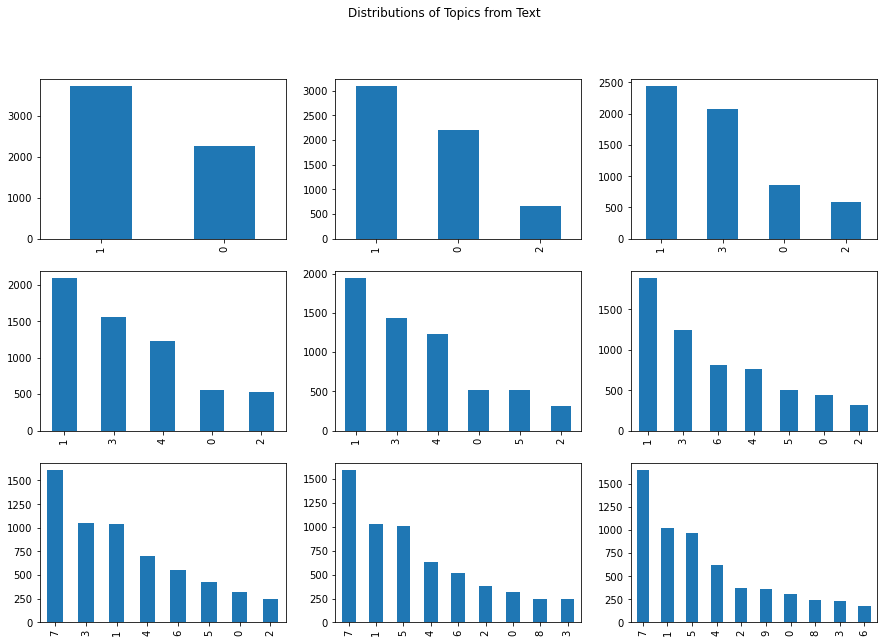

In [39]:
two = df['Two Topic'].value_counts()
three = df['Three Topic'].value_counts()
four = df['Four Topic'].value_counts()
five = df['Five Topic'].value_counts()
six = df['Six Topic'].value_counts()
seven = df['Seven Topic'].value_counts()
eight = df['Eight Topic'].value_counts()
nine = df['Nine Topic'].value_counts()
ten = df['Ten Topic'].value_counts()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
fig.suptitle('Distributions of Topics from Text')

two.plot(ax=axes[0,0], kind='bar')
three.plot(ax=axes[0,1], kind='bar')
four.plot(ax=axes[0,2], kind='bar')
five.plot(ax=axes[1,0], kind='bar')
six.plot(ax=axes[1,1], kind='bar')
seven.plot(ax=axes[1,2], kind='bar')
eight.plot(ax=axes[2,0], kind='bar')
nine.plot(ax=axes[2,1], kind='bar')
ten.plot(ax=axes[2,2], kind='bar')

## Using the three topic model above as an example, ratings from the ratings data set can be compiled for comparison across the different topics.

In [44]:
combined = pd.DataFrame()
combined['roaster'] = df['Roaster']
combined['origin'] = ratings['Coffee Origin']
combined['roast_level'] = ratings['Roast Level']
combined['group'] = df['Three Topic']
combined['rating'] = ratings.Overall
combined['aroma'] = ratings.Aroma
combined['body'] = ratings.Body
combined['flavor'] = ratings.Flavor
combined['aftertaste'] = ratings.Aftertaste
combined['acidity'] = ratings.Acidity
combined.sample(5)

,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
5799,Torrefazione Italia,NaN,NA,1,90,8,7,8,NaN,NaN
21,One Fresh Cup,Not disclosed,Medium,1,91,8,8,8,8,NaN
2163,Red Rooster Coffee Roaster,"Yirgacheffe growing region, south-central Ethi...",Light,0,92,8,9,9,8,8
1637,Vigilante Coffee,"Veracruz, Mexico",Light,1,92,9,8,9,8,8
5445,Horqueta Estate,NaN,NA,0,89,7.0,7.5,7.5,NaN,8.5


In [45]:
# How does the overall rating of coffee compare across the three topics?
combined.loc[combined.rating == 'NR','rating'] = '-999'
combined.rating = combined.rating.astype(int)
combined[combined.rating>0].groupby(by='group').rating.mean()

group
0    92.042043
1    89.483798
2    88.167683
Name: rating, dtype: float64

In [46]:
# How does the aroma rating of coffee compare across the three topics?
combined.loc[(combined.aroma == 'NR')|(combined.aroma == 'NA'),'aroma'] = '-999'
combined.aroma = combined.aroma.astype(float)
combined.aroma = combined.aroma.round(0)
combined[combined.aroma>0].groupby(by='group').aroma.mean()

group
0    8.625342
1    8.064727
2    7.735069
Name: aroma, dtype: float64

In [47]:
# How does the body rating of coffee compare across the three topics?
combined.loc[(combined.body == 'NR')|(combined.body == 'NA'),'body'] = '-999'
combined.body = combined.body.astype(float)
combined.body = combined.body.round(0)
combined[combined.body>0].groupby(by='group').body.mean()

group
0    8.311423
1    7.796951
2    7.555046
Name: body, dtype: float64

In [48]:
# How does the flavor rating of coffee compare across the three topics?
combined.loc[(combined.flavor == 'NR')|(combined.flavor == 'NA'),'flavor'] = '-999'
combined.flavor = combined.flavor.astype(float)
combined.flavor = combined.flavor.round(0)
combined[combined.flavor>0].groupby(by='group').flavor.mean()

group
0    8.775057
1    8.089315
2    7.851682
Name: flavor, dtype: float64

In [49]:
# How does the aftertaste rating of coffee compare across the three topics?
combined.aftertaste.fillna('-999',inplace=True)
combined.aftertaste = combined.aftertaste.astype(float)
combined.aftertaste = combined.aftertaste.round(0)
combined[combined.aftertaste>0].groupby(by='group').aftertaste.mean()

group
0    8.128481
1    7.842409
2    7.601887
Name: aftertaste, dtype: float64

In [50]:
# How does the acidity rating of coffee compare across the three topics?
combined.loc[(combined.acidity == 'NR')|(combined.acidity == 'NA')|(combined.acidity == 'na')|(combined.acidity == 'n/a'),'acidity'] = '-999'
combined.loc[(combined.acidity == 'Very Low'),'acidity'] = '1'
combined.loc[(combined.acidity == 'Low'),'acidity'] = '3'
combined.loc[(combined.acidity == 'Moderate'),'acidity'] = '5'
combined.acidity.fillna(-999,inplace=True)
combined.acidity = combined.acidity.astype(float)
combined.acidity = combined.acidity.round(0)
combined[combined.acidity>0].groupby(by='group').acidity.mean()

group
0    8.223223
1    7.490214
2    7.376884
Name: acidity, dtype: float64

In [52]:
three_groups = combined[combined['origin'].isnull() == False][['roaster','origin','roast_level','group']]
three_groups.sample(20)

,roaster,origin,roast_level,group
533,JBC Coffee Roasters,"Nensebo Woreda, Sidama, Ethiopia",Medium-Light,0
2706,De La Paz Coffee,"Ocotepeque Department, Honduras",Medium-Light,1
320,Paradise Roasters,"Chalatenango, El Salvador",Medium-Light,0
4477,Green Mountain Coffee,"Sidamo Province, southern Ethiopia.",NA,2
1667,Daktari Coffee,"Hambela Wamena District, Guji Zone, Oromia Reg...",Medium-Light,0
2096,Simon Hsieh's Aroma Roast Coffees,Colombia,Medium,1
2089,Propeller Coffee,Kenya; Brazil.,Medium-Light,1
5237,Joe to Go,"Chanchamayo growing region, south-central Peru",Medium-Dark,0
2932,Bonlife Coffee,Haiti.,Medium,1
510,Paradise Roasters,Madagascar,Medium-Light,0


In [54]:
with open('combined.pickle', 'wb') as to_write:
    pickle.dump(combined, to_write)

In [55]:
combined.head()

,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
0,Jackrabbit Java,Costa Rica,Medium-Light,1,93,9.0,9.0,9.0,8.0,8.0
1,Jackrabbit Java,"Nyamasheke District, Rwanda",Medium-Light,0,92,9.0,8.0,9.0,8.0,8.0
2,Red Rooster Coffee Roaster,"Los Naranjos, La Argentina, Huila Department, ...",Light,0,96,9.0,9.0,10.0,9.0,9.0
3,Paradise Roasters,"Huila, Colombia",Light,0,95,9.0,9.0,9.0,9.0,9.0
4,Kakalove Cafe,"Antioquia Department, Colombia",Medium-Light,1,95,9.0,9.0,9.0,9.0,9.0


In [57]:
df['rating'] =  combined['rating'] 

In [58]:
with open('df.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)